# Titanic - Machine Learning from Disaster

## descripcion 

## importacion de librerias

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import svm
from tensorflow.keras.callbacks import EarlyStopping

# Exploracion de datos

In [6]:
df_train = pd.read_csv("data/train.csv")
print("entrenamiento")
print(df_train.head(5))

entrenamiento
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN

In [129]:
df_test = pd.read_csv("data/test.csv")
print("test")
print(df_test.head(5))

test
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [18]:
print('Numero y Nombre columnas:',len(df_train.columns),df_train.columns)


Numero y Nombre columnas: 12 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [22]:
print("numero filas Train:",df_train.shape[0])
print("numero filas Test:",df_test.shape[0])

numero filas Train: 891
numero filas Test: 418


In [23]:
#tipos de datos
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [39]:
#funcion para eliminar las columnas de nombre , ID 

def eliminarColumnas(df,columnas):
    return df.drop(columnas, axis=1)

#funcion para llenar nulos con el promedio
def llenarNullConPromedio(columna):
    return columna.fillna(columna.mean())

#funcion para llenar nulos con aleatorio
def llenarNullConAleatorioCategoria(columna):
    categorias = columna.dropna().unique()  
    #cantidad_categorias = len(categorias)
    columna = columna.apply(lambda x: np.random.choice(categorias) if pd.isnull(x) else x)
    return columna

In [50]:
def limpiezaDeDatos(df):
    #se eliminara la columna cabin dado el alto numeo de nulos, y nombre , ID  , Ticket dado que podrias hacer que el modelo no generalice
    df=eliminarColumnas(df,['PassengerId', 'Name','Cabin','Ticket'])
    df['Age']=llenarNullConPromedio(df['Age'])
    df['Embarked']=llenarNullConAleatorioCategoria(df['Embarked'])
    return df
    
df_train_limpio=limpiezaDeDatos(df_train)
df_train_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### matiz de correlación

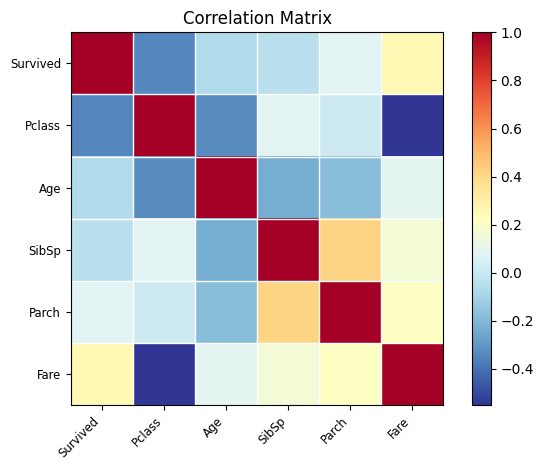

In [44]:
corr = df_train_limpio.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

### analisis por variables


In [53]:
df_train_limpio.Survived.unique()

array([0, 1], dtype=int64)

### one hot encode

In [47]:
#funcion para aplicar one hot encode categorico a ciertas columnas
def oneHotEncodeCategorico(df,columnas):
    return pd.get_dummies(df,columns=columnas)

In [56]:
columnas=['Pclass','Sex','Embarked']
df_train=oneHotEncodeCategorico(df_train_limpio,columnas)

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Pclass_1    891 non-null    uint8  
 6   Pclass_2    891 non-null    uint8  
 7   Pclass_3    891 non-null    uint8  
 8   Sex_female  891 non-null    uint8  
 9   Sex_male    891 non-null    uint8  
 10  Embarked_C  891 non-null    uint8  
 11  Embarked_Q  891 non-null    uint8  
 12  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(8)
memory usage: 41.9 KB


In [58]:
df_train_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [73]:
#separamos target y datos
X=eliminarColumnas(df_train,'Survived')
y=df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [137]:
#datos eval
test=limpiezaDeDatos(df_test)
columnas=['Pclass','Sex','Embarked']
test=oneHotEncodeCategorico(test,columnas)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    int64  
 2   Parch       418 non-null    int64  
 3   Fare        417 non-null    float64
 4   Pclass_1    418 non-null    uint8  
 5   Pclass_2    418 non-null    uint8  
 6   Pclass_3    418 non-null    uint8  
 7   Sex_female  418 non-null    uint8  
 8   Sex_male    418 non-null    uint8  
 9   Embarked_C  418 non-null    uint8  
 10  Embarked_Q  418 non-null    uint8  
 11  Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(8)
memory usage: 16.5 KB


## Xgboost

In [77]:
mat_xgbosttrain=xgb.DMatrix(X_train, label=y_train)
mat_xgbosttest=xgb.DMatrix(X_test, label=y_test)

- booster: El tipo de modelo de clasificación usado, por defecto gbtree.
- objective: El tipo de tarea de clasificación que realizaremos. Para clasificación binaria, nuestro caso, especificamos binary:logistic.
- max_depth: “Profundidad” o número de nodos de bifurcación de los árboles de decisión usados en el entrenamiento. Aunque una mayor profundidad puede devolver mejores resultados, también puede resultar en overfitting (sobre ajuste).
- eta: La tasa de aprendizaje del modelo. Un mayor valor llega más rápidamente al mínimo de la función objetivo, es decir, a un “mejor modelo”, pero puede “pasarse” de su valor óptimo. En cambio, un valor pequeño puede nunca llegar al valor óptimo de la función objetivo, incluso después de muchas iteraciones. En ambos casos, esto afecta el desempeño de nuestros modelos con nuevos.
-  nthread: El número de hilos computacionales que serán usados en el proceso de entrenamiento. Generalmente se refiere a los núcleos del procesador de tu equipo de cómputo, local o remoto, pero también pueden ser los núcleos de un GPU.
- nround: El número de iteraciones que se realizarán antes de detener el proceso de ajuste. Un mayor número de iteraciones generalmente devuelve mejores resultados de predicción, pero necesita más tiempo de entrenamiento y conlleva un riesgo de sobre ajuste si son demasiadas rondas.
https://medium.com/@jboscomendoza/tutorial-xgboost-en-python-53e48fc58f73

In [97]:
parametros = {"booster":"gbtree", "max_depth": 10, "eta": 0.3, "objective": "binary:logistic", "nthread":2}
rondas = 1000

In [98]:
#metricas de evaluacion
evaluacion = [(mat_xgbosttest, "eval"), (mat_xgbosttrain, "train")]

In [99]:
modelo = xgb.train(parametros, mat_xgbosttrain, rondas, evals=evaluacion)

[0]	eval-logloss:0.56741	train-logloss:0.54418
[1]	eval-logloss:0.50217	train-logloss:0.46007
[2]	eval-logloss:0.47333	train-logloss:0.40457
[3]	eval-logloss:0.44705	train-logloss:0.36390
[4]	eval-logloss:0.43704	train-logloss:0.33527
[5]	eval-logloss:0.41268	train-logloss:0.30860
[6]	eval-logloss:0.40233	train-logloss:0.29192
[7]	eval-logloss:0.39370	train-logloss:0.27681
[8]	eval-logloss:0.39547	train-logloss:0.26499
[9]	eval-logloss:0.40327	train-logloss:0.25455
[10]	eval-logloss:0.40695	train-logloss:0.24592
[11]	eval-logloss:0.40493	train-logloss:0.23903
[12]	eval-logloss:0.40495	train-logloss:0.23269
[13]	eval-logloss:0.40385	train-logloss:0.22784
[14]	eval-logloss:0.40508	train-logloss:0.22355
[15]	eval-logloss:0.40442	train-logloss:0.21780
[16]	eval-logloss:0.40962	train-logloss:0.21193
[17]	eval-logloss:0.41211	train-logloss:0.20790
[18]	eval-logloss:0.40737	train-logloss:0.20531
[19]	eval-logloss:0.40772	train-logloss:0.19841
[20]	eval-logloss:0.40515	train-logloss:0.19568
[2

[170]	eval-logloss:0.49966	train-logloss:0.07249
[171]	eval-logloss:0.49856	train-logloss:0.07229
[172]	eval-logloss:0.49910	train-logloss:0.07209
[173]	eval-logloss:0.49948	train-logloss:0.07193
[174]	eval-logloss:0.49923	train-logloss:0.07174
[175]	eval-logloss:0.50166	train-logloss:0.07155
[176]	eval-logloss:0.50322	train-logloss:0.07140
[177]	eval-logloss:0.50452	train-logloss:0.07128
[178]	eval-logloss:0.50326	train-logloss:0.07116
[179]	eval-logloss:0.50447	train-logloss:0.07099
[180]	eval-logloss:0.50506	train-logloss:0.07088
[181]	eval-logloss:0.50550	train-logloss:0.07075
[182]	eval-logloss:0.50460	train-logloss:0.07059
[183]	eval-logloss:0.50536	train-logloss:0.07050
[184]	eval-logloss:0.50550	train-logloss:0.07037
[185]	eval-logloss:0.50464	train-logloss:0.07024
[186]	eval-logloss:0.50324	train-logloss:0.07007
[187]	eval-logloss:0.50166	train-logloss:0.06998
[188]	eval-logloss:0.50257	train-logloss:0.06985
[189]	eval-logloss:0.50321	train-logloss:0.06971
[190]	eval-logloss:0

[338]	eval-logloss:0.52696	train-logloss:0.05772
[339]	eval-logloss:0.52681	train-logloss:0.05768
[340]	eval-logloss:0.52779	train-logloss:0.05762
[341]	eval-logloss:0.52787	train-logloss:0.05759
[342]	eval-logloss:0.52843	train-logloss:0.05755
[343]	eval-logloss:0.52811	train-logloss:0.05752
[344]	eval-logloss:0.52944	train-logloss:0.05747
[345]	eval-logloss:0.52959	train-logloss:0.05743
[346]	eval-logloss:0.52891	train-logloss:0.05740
[347]	eval-logloss:0.52819	train-logloss:0.05735
[348]	eval-logloss:0.52958	train-logloss:0.05729
[349]	eval-logloss:0.53049	train-logloss:0.05725
[350]	eval-logloss:0.53106	train-logloss:0.05720
[351]	eval-logloss:0.53026	train-logloss:0.05716
[352]	eval-logloss:0.53093	train-logloss:0.05711
[353]	eval-logloss:0.53064	train-logloss:0.05705
[354]	eval-logloss:0.52995	train-logloss:0.05700
[355]	eval-logloss:0.53142	train-logloss:0.05696
[356]	eval-logloss:0.53131	train-logloss:0.05692
[357]	eval-logloss:0.53139	train-logloss:0.05688
[358]	eval-logloss:0

[506]	eval-logloss:0.55430	train-logloss:0.05259
[507]	eval-logloss:0.55433	train-logloss:0.05256
[508]	eval-logloss:0.55404	train-logloss:0.05254
[509]	eval-logloss:0.55413	train-logloss:0.05253
[510]	eval-logloss:0.55464	train-logloss:0.05251
[511]	eval-logloss:0.55477	train-logloss:0.05249
[512]	eval-logloss:0.55460	train-logloss:0.05247
[513]	eval-logloss:0.55482	train-logloss:0.05245
[514]	eval-logloss:0.55443	train-logloss:0.05242
[515]	eval-logloss:0.55570	train-logloss:0.05240
[516]	eval-logloss:0.55633	train-logloss:0.05239
[517]	eval-logloss:0.55708	train-logloss:0.05237
[518]	eval-logloss:0.55714	train-logloss:0.05235
[519]	eval-logloss:0.55709	train-logloss:0.05233
[520]	eval-logloss:0.55787	train-logloss:0.05231
[521]	eval-logloss:0.55662	train-logloss:0.05228
[522]	eval-logloss:0.55659	train-logloss:0.05227
[523]	eval-logloss:0.55656	train-logloss:0.05225
[524]	eval-logloss:0.55716	train-logloss:0.05224
[525]	eval-logloss:0.55675	train-logloss:0.05221
[526]	eval-logloss:0

[674]	eval-logloss:0.56772	train-logloss:0.05007
[675]	eval-logloss:0.56818	train-logloss:0.05005
[676]	eval-logloss:0.56899	train-logloss:0.05003
[677]	eval-logloss:0.56891	train-logloss:0.05002
[678]	eval-logloss:0.56857	train-logloss:0.05001
[679]	eval-logloss:0.56899	train-logloss:0.05000
[680]	eval-logloss:0.56891	train-logloss:0.04999
[681]	eval-logloss:0.56894	train-logloss:0.04998
[682]	eval-logloss:0.56924	train-logloss:0.04997
[683]	eval-logloss:0.56934	train-logloss:0.04996
[684]	eval-logloss:0.56950	train-logloss:0.04995
[685]	eval-logloss:0.56959	train-logloss:0.04993
[686]	eval-logloss:0.57046	train-logloss:0.04992
[687]	eval-logloss:0.57082	train-logloss:0.04991
[688]	eval-logloss:0.57096	train-logloss:0.04990
[689]	eval-logloss:0.57104	train-logloss:0.04989
[690]	eval-logloss:0.57124	train-logloss:0.04988
[691]	eval-logloss:0.57118	train-logloss:0.04987
[692]	eval-logloss:0.57096	train-logloss:0.04985
[693]	eval-logloss:0.57114	train-logloss:0.04984
[694]	eval-logloss:0

[842]	eval-logloss:0.58009	train-logloss:0.04848
[843]	eval-logloss:0.58009	train-logloss:0.04848
[844]	eval-logloss:0.57999	train-logloss:0.04847
[845]	eval-logloss:0.58013	train-logloss:0.04846
[846]	eval-logloss:0.58015	train-logloss:0.04846
[847]	eval-logloss:0.58046	train-logloss:0.04845
[848]	eval-logloss:0.58062	train-logloss:0.04845
[849]	eval-logloss:0.58074	train-logloss:0.04844
[850]	eval-logloss:0.58090	train-logloss:0.04843
[851]	eval-logloss:0.58090	train-logloss:0.04843
[852]	eval-logloss:0.58065	train-logloss:0.04842
[853]	eval-logloss:0.58065	train-logloss:0.04842
[854]	eval-logloss:0.58002	train-logloss:0.04841
[855]	eval-logloss:0.58035	train-logloss:0.04840
[856]	eval-logloss:0.58021	train-logloss:0.04840
[857]	eval-logloss:0.58028	train-logloss:0.04839
[858]	eval-logloss:0.58036	train-logloss:0.04838
[859]	eval-logloss:0.58088	train-logloss:0.04837
[860]	eval-logloss:0.58142	train-logloss:0.04836
[861]	eval-logloss:0.58154	train-logloss:0.04835
[862]	eval-logloss:0

#### GridSearchCV

In [122]:
# Define el conjunto de parámetros que deseas explorar
parametros_grid = {
    'booster': ['gbtree'],
    'max_depth': [5, 10, 15],
    'eta': [0.001,0.01, 0.05, 0.1, 0.3, 0.5],
    'objective': ['binary:logistic'],
    'nthread': [2,4,6]
}

In [123]:
# Crea el clasificador XGBoost
modelo = xgb.XGBClassifier()

In [124]:
# Configura la búsqueda de parámetros con GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=parametros_grid, scoring='accuracy', cv=3, verbose=1)

In [125]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [126]:
print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'booster': 'gbtree', 'eta': 0.01, 'max_depth': 15, 'nthread': 2, 'objective': 'binary:logistic'}


In [127]:
# Predice con el modelo ajustado
y_pred = grid_search.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo:", accuracy)

Exactitud del modelo: 0.8444444444444444


In [131]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [138]:
result=grid_search.predict(test)
result

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [139]:
df_test['Survived']=result

In [140]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [143]:
df_result=df_test[['PassengerId','Survived']]
df_result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [144]:
df_result.to_csv("file.csv", index=False)
#Score: 0.76555

## suport vector machine

In [146]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [147]:
# Predice con el modelo ajustado
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud del modelo:", accuracy)

Exactitud del modelo: 0.7


## redes neuronales

In [205]:
import tensorflow as tf
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])


In [218]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)


In [219]:
early_stopping = EarlyStopping(monitor='val_accuracy',  # Puedes cambiar 'val_loss' a 'val_accuracy' u otra métrica según tus necesidades
                               patience=25,         # Número de épocas sin mejora antes de detener el entrenamiento
                               restore_best_weights=True,  # Restaurar los pesos del modelo a la mejor época
                               verbose=1)


In [220]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=150,callbacks=[early_stopping])


Epoch 1/150
26/26 [==============================] - 1s 8ms/step - loss: 0.5558 - accuracy: 0.7541 - val_loss: 0.3795 - val_accuracy: 0.8667
Epoch 2/150
26/26 [==============================] - 0s 4ms/step - loss: 0.4991 - accuracy: 0.7828 - val_loss: 0.3933 - val_accuracy: 0.8111
Epoch 3/150
26/26 [==============================] - 0s 4ms/step - loss: 0.4890 - accuracy: 0.7765 - val_loss: 0.4672 - val_accuracy: 0.7556
Epoch 4/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5927 - accuracy: 0.7453 - val_loss: 0.7480 - val_accuracy: 0.7444
Epoch 5/150
26/26 [==============================] - 0s 4ms/step - loss: 0.7463 - accuracy: 0.7403 - val_loss: 1.0198 - val_accuracy: 0.6889
Epoch 6/150
26/26 [==============================] - 0s 4ms/step - loss: 0.6555 - accuracy: 0.7591 - val_loss: 0.4051 - val_accuracy: 0.8333
Epoch 7/150
26/26 [==============================] - 0s 4ms/step - loss: 0.4843 - accuracy: 0.7803 - val_loss: 0.5105 - val_accuracy: 0.7444
Epoch 8/150
2

In [224]:
# Predice con el modelo ajustado
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_binary)
print("Exactitud del modelo:", accuracy)

Exactitud del modelo: 0.8666666666666667


In [223]:
y_pred

array([[0.06599493],
       [0.15175012],
       [0.0863625 ],
       [0.86742383],
       [0.69165766],
       [0.87972397],
       [0.5532268 ],
       [0.07917459],
       [0.7067011 ],
       [0.87125784],
       [0.26571605],
       [0.0450022 ],
       [0.32320148],
       [0.09364635],
       [0.1324429 ],
       [0.88817513],
       [0.25188205],
       [0.553878  ],
       [0.19118792],
       [0.30182603],
       [0.07214116],
       [0.2761537 ],
       [0.526519  ],
       [0.08988722],
       [0.06859036],
       [0.04779124],
       [0.31604856],
       [0.16292414],
       [0.05195031],
       [0.45926166],
       [0.09018695],
       [0.5671785 ],
       [0.4789943 ],
       [0.47238106],
       [0.09469275],
       [0.08634369],
       [0.37103203],
       [0.5532268 ],
       [0.9231084 ],
       [0.05565534],
       [0.18276447],
       [0.04151847],
       [0.05592599],
       [0.07456446],
       [0.40761077],
       [0.0697384 ],
       [0.09091379],
       [0.078

In [226]:
resultM=model.predict(test)
resultM=(resultM > 0.5).astype(int)
resultM

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
    

In [227]:
df_test['Survived']=resultM

In [228]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [229]:
df_result=df_test[['PassengerId','Survived']]
df_result.to_csv("file2.csv", index=False)